**Introduction to the Room Reservation System Project**

This Python project is a **room availability checking system** designed to help users identify available time slots for room bookings in a hotel or facility setting. Built using modern AI 
and workflow management tools, the system integrates a PostgreSQL database, a large language model (LLM), and a structured workflow to provide seamless user interactions.

### **Key Components and Features**

1. **Database Integration**  
   - The system uses a PostgreSQL database to store and manage room status data. A `room_status` table tracks room availability, with entries for each room's name, start/end times, and 
status (e.g., "booked" or "available"). Sample data initializes the database with historical and future room bookings.

2. **LLM-Powered Workflow**  
   - The project leverages **LangChain** and **Ollama** to integrate a large language model (e.g., Qwen3:14b) for natural language processing. This enables the system to understand user 
queries and generate human-friendly responses.

3. **Multi Agents-Based Architecture**  
   - **Room Checker Agent**: A specialized agent that uses a database tool (`tool__check_available_room_timeslots`) to query available room timeslots up to a specified target time. It 
extracts and processes datetime information from user input.
   - **Receptionist Agent**: Acts as a supervisor, managing user interactions. It routes queries to the Room Checker Agent when needed, handles ambiguous or out-of-scope requests, and 
ensures professional, user-friendly responses.

4. **Workflow Management with LangGraph**  
   - The system uses **LangGraph** to define and compile a state machine workflow. This ensures structured communication between agents, with clear start and end points for processing user 
questions.

5. **User Interaction**  
   - The project includes a `main()` function that demonstrates the system in action. For example, a user can ask, "Can you check any available timeslots for a room on 2023-10-02 after 
1pm?" The system processes the query, checks the database, and returns a list of available time slots.

### **Use Cases**  
- **Availability Checks**: Users can inquire about room availability at specific times.  
- **Ambiguous Queries**: The system gracefully handles unclear requests by redirecting to the appropriate agent or providing helpful guidance.  
- **Error Handling**: If database queries fail or return no results, the system provides polite fallback responses (e.g., suggesting the user contact the front desk).

### **Example Output**  
For the query *"I would like to book a room on 2023-10-02 after 1pm, can you check any available timeslots for me?"*, the system might respond with:  
*"Available timeslots: [2023-10-02 13:00, 2023-10-02 14:30]"*.

### **Why This Matters**  
This project exemplifies how AI-driven workflows can automate and enhance user interactions in real-world scenarios like hospitality management. By combining database queries, natural 
language understanding, and structured agent collaboration, it provides a scalable and intuitive solution for room availability checks.


In [1]:
############################
######      State     ######

from langgraph.graph.message import AnyMessage
from typing import List, Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import add_messages

class RoomReservationAgentState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], add_messages]


In [2]:

##########################
######      LLM     ######
import os
from langchain_ollama.llms import OllamaLLM, Client
from langchain_ollama import ChatOllama

class llm_ops:
    def get_llm(self) -> ChatOllama:
        llm_server_url    = os.getenv('LLM_SERVER_URL')
        llm_model_name    = "qwen3:14b"
        client = Client(llm_server_url)
        llm = ChatOllama(_client=client, model=llm_model_name, extract_reasoning=False)
        return llm

In [3]:

############################
######      Tools     ######
from datetime import datetime 
from langchain.tools import tool
import psycopg2
from dotenv import load_dotenv
load_dotenv()


        
@tool("tool__check_available_room_timeslots")
def tool__check_available_room_timeslots(targeted_timeslot: datetime):
    """
    Retrieves a list of available room timeslots from the database up to a specified target time.

    This function connects to a PostgreSQL database and queries the `public.room_status` table
    to find all distinct `start_time` entries that are less than or equal to the provided
    `targeted_timeslot`. It is intended to be used as a basic check for available room timeslots,
    though the logic may need further refinement depending on the specific database schema and
    availability rules.

    Args:
        targeted_timeslot (datetime): A datetime object representing the latest time up to
                                      which available timeslots should be considered.

    Returns:
        list: A list of datetime objects representing available room start times.
              Returns an empty list in case of any error during database operations.

    Raises:
        No exceptions are raised explicitly; any errors during execution are caught and
        logged, with an empty list returned as a fallback.

    Notes:
        - This function assumes the existence of a database table named `public.room_status`
          with a column `start_time`.
        - The current query provides a basic check and may not fully represent actual room
          availability (e.g., overlapping bookings are not considered).
        - Database connection parameters are retrieved from environment variables.

    Example:
        >>> from datetime import datetime
        >>> timeslot = datetime(2025, 3, 12, 10, 0)
        >>> available = tool__check_available_room_timeslots(timeslot)
        >>> print("Available timeslots:", available)
        Available timeslots: [datetime.datetime(2025, 3, 12, 9, 0), ...]
    """

    try:
        # Establish a connection to the PostgreSQL database
        db_host = os.getenv('DB_HOST')
        db_port = int(os.getenv('DB_PORT'))
        db_user = os.getenv('DB_USER')
        db_name = "portfolio"
        db_password = os.getenv('DB_PASSWORD')
        
        conn = psycopg2.connect(
            dbname=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port
        )
        cur = conn.cursor()

        #   query available with certain timeslot
        query = """
            SELECT DISTINCT start_time
            FROM public.room_status as rs
            WHERE
                rs.start_time <= %s            
        """
        # Execute the query with the targeted_timeslot parameter
        cur.execute(query, (targeted_timeslot,))
        
        # Extract only the room names from the results
        available_timeslots = [row[0] for row in cur.fetchall()]

        return available_timeslots



    except Exception as e:
        print(f"An error occurred: {e}")
        return []

    finally:
        # Ensure the cursor and connection are closed properly
        if 'cur' in locals():
            cur.close()
        if 'conn' in locals():
            conn.close()

In [4]:
###########################################################
######      Workflow (include Agents and Prompts)    ######
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from IPython.display import Image, display

class workflow_ops:
    def __init__(self):
        self.llms = llm_ops()

    def workflow__room_reservation(self, question: str):
        llm = self.llms.get_llm()

        ###     create react agent
        prompt__room_checker = """
            You are a **Room Availability Checker Agent**, designed to help users find available room timeslots up to a specified date and time.

            ### 🎯 Objective:
            When a user asks about room availability, you will:
            1. **Understand the request** — identify the target date and time from the query.
            2. **Use the tool** `tool__check_available_room_timeslots` with the extracted `targeted_timeslot` parameter.
            3. **Return the result** — list the available timeslots in a clear and user-friendly format.
            4. **Handle errors gracefully** — if an error occurs, inform the user and return an empty list.

            ### 📌 Instructions:
            - If the user's query mentions a **specific date and time**, extract it and use it as the `targeted_timeslot`.
            - If the query is **ambiguous** (e.g., "Check availability for next week"), assume a default or ask for clarification (but this agent is not designed to ask questions — use the current date 
            as a fallback).
            - Always format the output as a **list of available timeslots**, using the format:  
            `"Available timeslots: [datetime1, datetime2, ...]"`.
            - If no timeslots are available or an error occurs, return:  
            `"No available timeslots found or an error occurred."`

            ### ✅ Example:
            **User Query:** "Are there any rooms available at 2 PM tomorrow?"
            **Action:** Use the tool with `targeted_timeslot = datetime(2025, 4, 5, 14, 0)`
            **Response:**  
            "Available timeslots: [2025-04-05 10:00:00, 2025-04-05 11:00:00]"

            ### ❗ Error Handling:
            - If the database is unreachable or the query fails, return:  
            `"An error occurred while checking room availability."`

            ### 🔍 Notes:
            - This agent assumes the user's query is clear and provides a valid date/time.
            - You will **not** ask clarifying questions — use the best available information.
            - The tool `tool__check_available_room_timeslots` returns a list of `datetime` objects; you will format these for the user.
            - The tool checks for `start_time <= targeted_timeslot`, which may not fully reflect room availability (e.g., overlapping bookings are not considered).

            ---

            You are now ready to process user queries about room availability.
            """

        room_checker = create_react_agent(
            model=llm,
            tools=[tool__check_available_room_timeslots],
            prompt=prompt__room_checker,
            debug=False,
            name="room_checker"
        )

        ###     create supervisor agent
        prompt__receptionist = """
            You are a **Receptionist Agent**, designed to manage user interactions and coordinate with other agents to provide assistance in a hotel or facility environment.

            ### 🎯 Objective:
            When a user interacts with you, you will:
            1. **Greet the user** and ask how you can assist them.
            2. **Determine the nature of the request** (e.g., room availability, booking, directions, etc.).
            3. **Use the `room_checker` agent only when the request is about checking room availability up to a specific time**.
            4. **Provide a clear and professional response** to the user, using the results from the `room_checker` or other relevant information.
            5. **Handle errors gracefully** — if the `room_checker` fails or returns no results, inform the user appropriately.
            6. **Alternatives recommendation** recommend user any all available timeslots after interact with room_check agent

            ### 📌 Instructions:
            - Use the `room_checker` agent **only** when the user asks about **room availability**.
            - If the user asks for **room booking**, **directions**, or **other services**, respond politely and clarify that you cannot perform those actions but can assist with availability checks.
            - Always format the response in a **friendly and professional tone**, using clear language and appropriate punctuation.
            - If the `room_checker` returns an error or no results, respond with:
            `"I'm unable to check room availability at the moment. Please try again later or contact the front desk for assistance."`
            - If the user's request is **ambiguous**, ask for clarification or proceed with the best available information.

            ### ✅ Example:
            **User Query:** "Do you have any rooms available at 2 PM tomorrow?"
            **Action:** Use the `room_checker` agent with `targeted_timeslot = datetime(2025, 4, 5, 14, 0)`
            **Response:**
            "Available timeslots: [2025-04-05 10:00:00, 2025-04-05 11:00:00]"

            **User Query:** "I want to book a room for tomorrow."
            **Response:**
            "I currently cannot assist with room bookings. However, I can help you check the availability of rooms. Would you like me to check for availability at a specific time?"

            **User Query:** "Where is the nearest restrooms?"
            **Response:**
            "I’m unable to provide directions or locate facilities within the building. Please ask a staff member for assistance."

            ### ❗ Error Handling:
            - If the `room_checker` agent returns an error or no results, respond with:
            `"I'm unable to check room availability at the moment. Please try again later or contact the front desk for assistance."`
            - If the user's request is unclear or outside the scope of your capabilities, politely inform them and offer to help with availability checks.

            ### 🔍 Notes:
            - This agent is **not designed to perform bookings** or other administrative tasks — it only coordinates with the `room_checker` agent.
            - You will **not ask questions** unless the user's request is ambiguous — use the best available information to proceed.
            - The `room_checker` agent returns a list of `datetime` objects; you will format these for the user in a clear and user-friendly way.
            - Always keep the tone **professional and helpful**, even in cases of errors or limitations.

            ---

            You are now ready to interact with users and manage the `room_checker` agent to provide assistance with room availability.
            """

        receptionist = create_supervisor(
            [room_checker],
            model=llm,
            prompt=prompt__receptionist,
            supervisor_name='receptionist'
        )

        app = receptionist.compile()
        print("below is multi-agent workflow diagram")
        display(Image(app.get_graph().draw_mermaid_png()))


        ###     human question
        print(f"[workflow__room_reservation] human_question: {question}")

        response = app.invoke({"messages": [{"role": "user", "content": question}]})

        return response


below is multi-agent workflow diagram


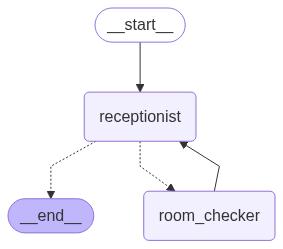

[workflow__room_reservation] human_question: I would like to book a room on 2023-10-02 after 1pm, can you check any availabile timeslots for me?


Task receptionist with path ('__pregel_pull', 'receptionist') wrote to unknown channel is_last_step, ignoring it.
Task receptionist with path ('__pregel_pull', 'receptionist') wrote to unknown channel remaining_steps, ignoring it.




ai final answer as below
<think>
Okay, the user asked for room availability on 2023-10-02 after 1pm. The room_checker agent returned a timeslot at 10:00 AM on that date. But the user specifically wanted after 1pm, so there's a mismatch here.

First, I need to check if the timeslot provided by the room_checker is correct. The targeted_timeslot parameter was set to 13:00 (1pm), but the available timeslot is at 10:00 AM. That suggests that the room_checker might have returned timeslots up to the targeted time, but not after. However, the user wants times after 1pm, so there are no matches.

Wait, maybe there's a misunderstanding. The room_checker's function is to check availability up to a specific time, not after. So if the user wants after 1pm, the tool might not have the capability to check that. The available timeslot at 10:00 AM is before the requested time, so it's not suitable.

In this case, the correct response is to inform the user that there are no available timeslots after 1

In [5]:

##############################
######      chatbot     ######

def main():
    human_question = "I would like to book a room on 2023-10-02 after 1pm, can you check any availabile timeslots for me?"
    w = workflow_ops()
    ai_answers = w.workflow__room_reservation(question=human_question)
    last_msg = ai_answers['messages'][-1].content

    print("\n\nai final answer as below")
    print(last_msg)
    return

if __name__ == "__main__":
    main()